**Author: Fiona Jiaqi Wu** 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Import Datasets

In [3]:
df1 = pd.read_csv('/Users/Fiona/Desktop/Prosper/2019.csv')

In [4]:
df1.shape

(189941, 370)

In [5]:
df2 = pd.read_csv('/Users/Fiona/Desktop/Prosper/2020.csv')

In [6]:
df2.shape

(83747, 377)

In [7]:
df3 = pd.read_csv('/Users/Fiona/Desktop/Prosper/2018.csv')

In [8]:
df1['listing_start_date'] = pd.to_datetime(df1['listing_start_date'])
df1['listing_end_date'] = pd.to_datetime(df1['listing_end_date'])
df1['listing_creation_date'] = pd.to_datetime(df1['listing_creation_date'])
df2['listing_start_date'] = pd.to_datetime(df2['listing_start_date'])
df2['listing_end_date'] = pd.to_datetime(df2['listing_end_date'])
df2['listing_creation_date'] = pd.to_datetime(df2['listing_creation_date'])
df3['listing_start_date'] = pd.to_datetime(df3['listing_start_date'])
df3['listing_end_date'] = pd.to_datetime(df3['listing_end_date'])
df3['listing_creation_date'] = pd.to_datetime(df3['listing_creation_date'])

### Combine datasets (2018, 2019, 2020)

In [9]:
df1 = df1[df1.columns & df2.columns & df3.columns]
df2 = df2[df1.columns & df2.columns & df3.columns]
df3 = df3[df1.columns & df2.columns & df3.columns]

In [10]:
print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df1.shape[0] + df2.shape[0] + df3.shape[0])

(189941, 368)
(83747, 368)
(227524, 368)
501212


In [11]:
combined = pd.concat([df1, df2, df3], ignore_index=True)

In [12]:
combined.shape

(501212, 368)

In [13]:
combined.head()

,member_key,listing_number,listing_start_date,listing_end_date,listing_creation_date,listing_status,listing_status_reason,listing_amount,amount_funded,amount_remaining,percent_funded,partial_funding_indicator,funding_threshold,prosper_rating,estimated_return,estimated_loss_rate,lender_yield,effective_yield,borrower_rate,borrower_apr,listing_term,listing_monthly_payment,prosper_score,listing_category_id,income_range,income_range_description,stated_monthly_income,employment_status_description,occupation,months_employed,prior_prosper_loans_active,prior_prosper_loans,prior_prosper_loans_principal_borrowed,prior_prosper_loans_principal_outstanding,prior_prosper_loans_cycles_billed,prior_prosper_loans_ontime_payments,prior_prosper_loans_late_cycles,prior_prosper_loans_late_payments_one_month_plus,max_prior_prosper_loan,min_prior_prosper_loan,lender_indicator,group_indicator,channel_code,investment_typeid,investment_type_description,AT01S,AT02S,AT03S,AT06S,AT09S,AT12S,AT20S,AT21S,AT24S,AT25S,AT27S,AT28A,AT28B,AT29S,AT32S,AT34A,AT34B,AT35A,AT35B,AT36S,AT57S,AT101S,AT101B,AU01S,AU02S,AU03S,AU06S,AU09S,AU12S,AU20S,AU21S,AU24S,AU25S,AU27S,AU28S,AU29S,AU32S,AU34S,AU35S,AU36S,AU57S,AU101S,BC01S,BC02S,BC03S,BC06S,BC09S,BC12S,BC20S,BC21S,BC24S,BC25S,BC27S,BC28S,BC29S,BC32S,BC34S,BC35S,BC36S,BC57S,BC101S,BC102S,BC103S,BC106S,BC107S,BC108S,BC110S,CO01S,CO02S,CO03S,CO04S,CO05S,CO06S,CO07S,G001B,G002B,G003S,G020S,G041S,G042S,G043S,G051S,G057S,G058S,G059S,G061S,G063S,G064S,G066S,G068S,G069S,G071S,G093S,G094S,G095S,G099S,G100S,G102S,G103S,G104S,G105S,G209S,G210S,G211S,G212S,G217S,G218B,G218D,G219B,G219D,G220B,G220D,G221B,G221D,G222S,G223S,G225S,G226S,G227S,G228S,G230S,G231S,G232S,G233S,G234S,G235S,G236S,G237S,G238S,G239S,G240S,G241S,G960S,G980S,G990S,HI01S,HI02S,HI03S,HI06S,HI09S,HI12S,HI20S,HI21S,HI24S,HI25S,HI27S,HI28S,HI29S,HI32S,HI34S,HI35S,HI36S,HI57S,HI101S,HR01S,HR02S,HR03S,HR06S,HR09S,HR12S,HR20S,HR21S,HR24S,HR25S,HR27S,HR28S,HR29S,HR32S,HR34S,HR35S,HR36S,HR57S,HR101S,IN01S,IN02S,IN03S,IN06S,IN09S,IN12S,IN20S,IN21S,IN24S,IN25S,IN27S,IN28S,IN29S,IN32S,IN34S,IN35S,IN36S,IN57S,IN101S,MT01S,MT02S,MT03S,MT06S,MT09S,MT12S,MT20S,MT21S,MT24S,MT25S,MT27S,MT28S,MT29S,MT32S,MT34S,MT34B,MT34C,MT35S,MT36S,MT47S,MT57S,MT101S,OF01S,RE01S,RE02S,RE03S,RE06S,RE09S,RE12S,RE20S,RE21S,RE24S,RE25S,RE27S,RE28S,RE29S,RE32S,RE33S,RE34S,RE35S,RE36S,RE57S,RE101S,RE102S,RT01S,RT02S,RT03S,RT06S,RT09S,RT12S,RT20S,RT21S,RT24S,RT25S,RT27S,RT28S,RT29S,RT32S,RT34S,RT35S,RT36S,RT57S,RT101S,RT201S,S004S,S061S,S062S,S064A,S068A,S071A,ST01S,ST02S,ST03S,ST06S,ST09S,ST12S,ST20S,ST21S,ST24S,ST25S,ST27S,ST28S,ST29S,ST32S,ST34S,ST35S,ST36S,ST45S,ST50S,ST57S,ST99S,ST101S,ATAP01,HIAP01,HRAP01,INAP01,MTAP01,REAP01,S063S,S063A,S207S,S207A,G106S,G099A,S206S,S209S,S204S,G242S,G243S,G244S,CV01,CV04,CV10,CV11,CV12,CV13,CV14,CV15,CV16,CV17,CV18,CV19,CV20,CV21,CV22,CV23,CV24,TUFicoRange,TUFicoDate,dti_wprosper_loan,CoBorrowerApplication
0,C20537292024540481062ED,10712027,2020-01-14,2020-01-14,2019-12-14,6,Completed,27000.0,27000.0,0.0,1.0,False,1.0,B,0.0664,0.0494,0.1174,0.1158,0.1274,0.1636,36,906.36,9.0,1,4,"$50,000-74,999",5560.0000,Employed,Civil Service,120.0,0,2,18000.0,0.00,3.0,3.0,0.0,0.0,15000.0,3000.0,0,False,80000,3,Whole,29.0,10.0,10.0,1.0,2.0,10.0,209.0,6.0,10.0,9.0,8.0,208750.0,42500.0,9.0,83232.0,60.0,63.0,12421.0,3327.0,71.0,0.0,124207.0,26619.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,7.0,3.0,3.0,0.0,0.0,3.0,209.0,30.0,3.0,3.0,3.0,17900.0,3.0,7269.0,96.0,5732.0,71.0,0.0,17197.0,5967.0,5732.0,0.0,3.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,12.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.0,-4.0,-4.0,0.0,-4.0,-4.0,-4.0,-4.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-4.0,0.0,-4.0,-4.0,-1.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,-4.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,0.0,0.0

In [15]:
combined['group_indicator'].value_counts()

False    500496
True        716
Name: group_indicator, dtype: int64

### Data Cleaning (dealing with NaN values)

In [28]:
combined = combined.loc[combined['AT01S'].isnull() == False]
combined = combined.loc[combined['RT35S'].isnull() == False]
combined.shape

(500367, 368)

In [29]:
#fill missing prosper scores with its median
prosper_median = combined['prosper_score'].median()
combined['prosper_score'] = combined['prosper_score'].fillna(prosper_median)

In [30]:
#replace the missing values in occupation with the second most common value - professional (the most common one is Other)
combined['occupation'] = combined['occupation'].fillna('Professional')

In [31]:
#fill missing values in months employed with its median
employed_median = combined['months_employed'].median()
combined['months_employed'] = combined['months_employed'].fillna(employed_median)

In [32]:
combined = combined.fillna(0)

In [33]:
#convert percent_funded to % style
combined['percent_funded'] = combined['percent_funded']*100

### Prosper rating 
Prosper Ratings allow potential investors to easily consider a loan application's level of risk because the rating represents an estimated average annualized loss rate range to the investor. 

AA  0.00-1.99% = 6\
A	2.00–3.99% = 5\
B	4.00–5.99% = 4 \
C	6.00–8.99% = 3 \
D	9.00–11.99% = 2\
E	12.00–14.99% = 1 \
HR	≥ 15.00% = 0

In [34]:
#examine the number of ratings in each category
combined['prosper_rating'].value_counts()

B     120145
C     116686
A     114527
AA     66705
D      49711
E      24933
HR      7660
Name: prosper_rating, dtype: int64

In [35]:
#convert categorical varaible - prosper rating to numerical ones (to include them in the model)
def rating_nu(x):
    if x == 'AA':
        return 7
    elif x == 'A':
        return 6
    elif x == 'B':
        return 5
    elif x == 'C':
        return 4 
    elif x == 'D':
        return 3
    elif x == 'E':
        return 2
    elif x == 'HR':
        return 1
    
combined['prosper_rating_nu'] = combined['prosper_rating'].apply(lambda x: rating_nu(x))

### FICO score

In [36]:
#examine the number of individuals in each FICO range
combined['TUFicoRange'].value_counts()

700-719    90163
680-699    86729
720-739    74851
660-679    73824
740-759    52999
640-659    45206
760-779    34106
780-799    23921
800-819    13799
820-850     4769
Name: TUFicoRange, dtype: int64

In [37]:
# convert fico score range to numerical ones, 10 is the highest
def fico_range_nu(x):
    if x == '820-850':
        return 10
    if x == '800-819':
        return 9
    elif x == '780-799':
        return 8
    elif x == '760-779':
        return 7
    elif x == '740-759':
        return 6
    elif x == '720-739':
        return 5
    elif x == '700-719':
        return 4
    elif x == '680-699':
        return 3 
    elif x == '660-679':
        return 2
    elif x == '640-659':
        return 1
    
combined['TUFicoRange_Nu'] = combined['TUFicoRange'].apply(lambda x: fico_range_nu(x))

In [38]:
# convert the rest of the categorical variables into numerical ones
combined['listing_status_reason'] = combined['listing_status_reason'].astype('category')
combined['listing_status_reason_Nu'] = combined['listing_status_reason'].cat.codes
combined['partial_funding_indicator'] = combined['partial_funding_indicator'].astype('category')
combined['partial_funding_indicator_Nu'] = combined['partial_funding_indicator'].cat.codes
combined['employment_status_description'] = combined['employment_status_description'].astype('category')
combined['employment_status_description_Nu'] = combined['employment_status_description'].cat.codes
combined['occupation'] = combined['occupation'].astype('category')
combined['occupation_Nu'] = combined['occupation'].cat.codes
combined['investment_type_description'] = combined['investment_type_description'].astype('category')
combined['investment_type_description_Nu'] = combined['investment_type_description'].cat.codes
combined['CoBorrowerApplication'] = combined['CoBorrowerApplication'].astype('category')
combined['CoBorrowerApplication_Nu'] = combined['CoBorrowerApplication'].cat.codes

In [39]:
print(combined.shape)

(500367, 376)


### Estimated loss rate with defined classes 

In [40]:
# create 10 elr classes with equal intervals
min = 0.002700
max = 0.177500
bins = (0.177500-0.002700) / 10

def elr_class(x):
    if x <= min + bins:
        return 1 
    elif min + bins < x <= min + 2 * bins:
        return 2
    elif min + 2 * bins < x <= min + 3 * bins:
        return 3
    elif min + 3 * bins < x <= min + 4 * bins:
        return 4
    elif min + 4 * bins < x <= min + 5 * bins:
        return 5 
    elif min + 5 * bins < x <= min + 6 * bins:
        return 6
    elif min + 6 * bins < x <= min + 7 * bins:
        return 7
    elif min + 7 * bins < x <= min + 8 * bins:
        return 8
    elif min + 8 * bins < x <= min + 9 * bins:
        return 9
    elif min + 9 * bins < x:
        return 10

combined['elr_bin10_class'] = combined['estimated_loss_rate'].apply(lambda x: elr_class(x))

In [41]:
# create 5 elr classes with equal intervals
bin5 = (0.177500-0.002700) / 5

def elr_class_5(x):
    if x <= min + bin5:
        return 1 
    elif min + bin5 < x <= min + 2 * bin5:
        return 2
    elif min + 2 * bin5 < x <= min + 3 * bin5:
        return 3
    elif min + 3 * bin5 < x <= min + 4 * bin5:
        return 4
    elif min + 4 * bin5 < x:
        return 5 


combined['elr_bin5_class'] = combined['estimated_loss_rate'].apply(lambda x: elr_class_5(x))

In [42]:
bins20 = (0.177500-0.002700) / 20

def elr_class20(x):
    if x <= min + bins20:
        return 1 
    elif min + bins20 < x <= min + 2 * bins20:
        return 2
    elif min + 2 * bins20 < x <= min + 3 * bins20:
        return 3
    elif min + 3 * bins20 < x <= min + 4 * bins20:
        return 4
    elif min + 4 * bins20 < x <= min + 5 * bins20:
        return 5 
    elif min + 5 * bins20 < x <= min + 6 * bins20:
        return 6
    elif min + 6 * bins20 < x <= min + 7 * bins20:
        return 7
    elif min + 7 * bins20 < x <= min + 8 * bins20:
        return 8
    elif min + 8 * bins20 < x <= min + 9 * bins20:
        return 9
    elif min + 9 * bins20 < x <= min + 10 * bins20:
        return 10
    elif min + 10 * bins20 < x <= min + 11 * bins20:
        return 11
    elif min + 11 * bins20 < x <= min + 12 * bins20:
        return 12
    elif min + 12 * bins20 < x <= min + 13 * bins20:
        return 13
    elif min + 13 * bins20 < x <= min + 14 * bins20:
        return 14
    elif min + 14 * bins20 < x <= min + 15 * bins20:
        return 15
    elif min + 15 * bins20 < x <= min + 16 * bins20:
        return 16
    elif min + 16 * bins20 < x <= min + 17 * bins20:
        return 17
    elif min + 17 * bins20 < x <= min + 18 * bins20:
        return 18
    elif min + 18 * bins20 < x <= min + 19 * bins20:
        return 19
    elif min + 19 * bins20 < x:
        return 20

combined['elr_bin20_class'] = combined['estimated_loss_rate'].apply(lambda x: elr_class20(x))

### Dealing with special labels (negative values) and drop unnecessary columns
only get the numerical data to train the model

#### special labels - TransUnion data elements 
-1	No trades this type \
-2	Not verified in time period \
-3	No open trades this type \
-4	No trades on file \
-5	Cannot calculate (required data for calculation is missing)\
-6	No accounts on file \
-7	No trades opened for required time \
999	No detected event for “Months Since” attributes (e.g. at36S=999 means no delinquency information) \


In [43]:
#create a copy of combined, call it combined2 
combined2 = combined.copy()

In [44]:
#use listing_start_date as the sorting method, and drop the irrelevant columns 
combined2 = combined2.drop(['listing_end_date', 'listing_creation_date', 'member_key', 'listing_number'], axis = 1)

In [45]:
#replace all the negative special labels by 0
combined2_num = combined2._get_numeric_data()
combined2_num[combined2_num < 0] = 0

### In sample testing - use 01-01-2019 to 02-28-2020

In [46]:
# test months from Jan 2019 to Feb 2020 (tried from July 2019 to Feb 2020, the in sample accuracy is below 70%, this sample period gives me 80%)
sub1 = combined2.loc[(combined2['listing_start_date'] >= '2019-03-01') & (combined2['listing_start_date'] <= '2020-02-28')]

In [47]:
#only get numerical numbers to train the model
sub1 = sub1.select_dtypes(include=np.number)
print(sub1.shape)

(181712, 363)


#### 5 classes elr 

In [48]:
#define X and y
y = sub1['elr_bin5_class']
X = sub1.drop(['estimated_loss_rate', 'elr_bin10_class', 'elr_bin5_class'], axis = 1)

In [49]:
March_2020 = combined2.loc[(combined2['listing_start_date'] >= '2020-03-01') & (combined2['listing_start_date'] <= '2020-03-31')]

In [50]:
elr_March = pd.DataFrame(March_2020['estimated_loss_rate'].value_counts())
elr_March.sort_index(inplace = True)

In [51]:
#80% of the data randomly selected to train the model, the rest of 20% is to test the model accuracy
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021)

In [52]:
#random forest
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=0, 
                             criterion='entropy') # Use entropy criterion to define feature importance

# fit the model using training data
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [53]:
y_test_predicted = rfc.predict(X_test)

In [54]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_test_predicted)

0.9968632198772803

#### 10 classes elr

In [55]:
#define X and y
y_10 = sub1['elr_bin10_class']
X_10 = sub1.drop(['estimated_loss_rate', 'elr_bin10_class', 'elr_bin5_class'], axis = 1)

In [56]:
from sklearn.model_selection import train_test_split
X_train_10, X_test_10, y_train_10, y_test_10 = train_test_split(X_10, y_10, test_size=0.2, random_state=2021)

In [57]:
from sklearn.ensemble import RandomForestClassifier
rfc_10 = RandomForestClassifier(random_state=0, 
                             criterion='entropy') # Use entropy criterion to define feature importance

# fit the model using training data
rfc_10.fit(X_train_10, y_train_10)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [58]:
y_test_10_predicted = rfc_10.predict(X_test_10)

In [59]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test_10, y_test_10_predicted)

0.9938640178301186

#### 20 classes elr

In [60]:
#define X and y
y_20 = sub1['elr_bin20_class']
X_20 = sub1.drop(['estimated_loss_rate', 'elr_bin10_class', 'elr_bin5_class', 'elr_bin20_class'], axis = 1)

In [61]:
from sklearn.model_selection import train_test_split
X_train_20, X_test_20, y_train_20, y_test_20 = train_test_split(X_20, y_20, test_size=0.2, random_state=2021)

In [62]:
#random forest
from sklearn.ensemble import RandomForestClassifier
rfc_20 = RandomForestClassifier(random_state=0, 
                             criterion='entropy') # Use entropy criterion to define feature importance

# fit the model using training data
rfc_20.fit(X_train_20, y_train_20)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [63]:
y_test_20_predicted = rfc_20.predict(X_test_20)

In [64]:
accuracy_score(y_test_20, y_test_20_predicted)

0.9460418787661998

#### Note
As you increase the number of classes to 20, the in sample accuracy decreased dramatically. I don't recommend to have more than 10 classes.

### Out of sample testing

In [65]:
# use October 2019 to Feb 2020 as training set gives me the best accuracy prediction
sub2_train = combined2.loc[(combined2['listing_start_date'] >= '2019-03-01') & (combined2['listing_start_date'] <= '2020-02-28')]
sub2_test = combined2.loc[(combined2['listing_start_date'] >= '2020-03-01') & (combined2['listing_start_date'] <= '2020-08-31')]

In [66]:
sub2_train = sub2_train.select_dtypes(include=np.number)
sub2_test = sub2_test.select_dtypes(include=np.number)
print(sub2_train.shape)
print(sub2_test.shape)

(181712, 363)
(46828, 363)


### 5 classes out of sample testing

In [67]:
#define X and y
X_train_sub2_bin5 = sub2_train.drop(['estimated_loss_rate', 'elr_bin10_class', 'elr_bin5_class', 'elr_bin20_class'], axis = 1)
y_train_sub2_bin5 = sub2_train['elr_bin5_class']
X_test_sub2_bin5 = sub2_test.drop(['estimated_loss_rate', 'elr_bin10_class', 'elr_bin5_class', 'elr_bin20_class'], axis = 1)
y_test_sub2_bin5 = sub2_test['elr_bin5_class']

In [68]:
# random forest 
from sklearn.ensemble import RandomForestClassifier
rfc_out_5 = RandomForestClassifier(random_state=0, 
                             criterion='entropy') # Use entropy criterion to define feature importance

# Train the classifier
rfc_out_5.fit(X_train_sub2_bin5, y_train_sub2_bin5)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [69]:
y_test_sub2_bin5_hat = rfc_out_5.predict(X_test_sub2_bin5)

In [70]:
elr_5 = pd.DataFrame({'elr_bin5_class': y_test_sub2_bin5, 'elr_bin5_class_hat': y_test_sub2_bin5_hat})

In [71]:
# train - from Oct 2019 to Feb 2020, test - from March 2020 to May 2020
# even lower - there must be some model adjustment
print('The out of sample accuracy is:', accuracy_score(y_test_sub2_bin5, y_test_sub2_bin5_hat) *100,'%')

The out of sample accuracy is: 74.26326129666012 %


#### Note: test with different train and test period
The prediction power increased A LOT if only to predict March (indicate a model change after the pandemic) \
The prediction power is even more if you predict Feb 2020 (without including it in the training sample) \
Another indication that the model changed in March 2020

In [206]:
# train - from Oct 2019 to Feb 2020, test - March 2020
# accuracy decreased...another sign of change of model
#print('The out of sample accuracy is:', accuracy_score(y_test_sub2_bin5, y_test_sub2_bin5_hat) *100,'%')

The out of sample accuracy is: 74.26326129666012 %


In [134]:
# train - from Oct 2019 to Jan 2020, test - Feb 2020
# even lower - there must be some model adjustment
#print('The out of sample accuracy is:', accuracy_score(y_test_sub2_bin5, y_test_sub2_bin5_hat) *100,'%')

The out of sample accuracy is: 73.33432988810114 %


### 10 classes out of sample results

In [72]:
#define X and y
X_train_sub2_bin10 = sub2_train.drop(['estimated_loss_rate', 'elr_bin10_class', 'elr_bin5_class', 'elr_bin20_class'], axis = 1)
y_train_sub2_bin10 = sub2_train['elr_bin10_class']
X_test_sub2_bin10 = sub2_test.drop(['estimated_loss_rate', 'elr_bin10_class', 'elr_bin5_class', 'elr_bin20_class'], axis = 1)
y_test_sub2_bin10 = sub2_test['elr_bin10_class']

In [73]:
# random forest 
from sklearn.ensemble import RandomForestClassifier
rfc_out_10 = RandomForestClassifier(random_state=0, 
                             criterion='entropy') # Use entropy criterion to define feature importance

# Train the classifier
rfc_out_10.fit(X_train_sub2_bin10, y_train_sub2_bin10)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [74]:
y_test_sub2_bin10_hat = rfc_out_10.predict(X_test_sub2_bin10)

In [75]:
elr_10 = pd.DataFrame({'elr_bin10_class': y_test_sub2_bin10, 'elr_bin10_class_hat': y_test_sub2_bin10_hat})
elr_10.head()

,elr_bin10_class,elr_bin10_class_hat
196,3,3
1453,3,3
189963,3,3
190000,6,7
190001,3,3


In [76]:
# train - from Oct 2019 to Feb 2020, test - from March 2020 to May 2020
print('The out of sample accuracy is:', accuracy_score(y_test_sub2_bin10, y_test_sub2_bin10_hat) *100,'%')

The out of sample accuracy is: 50.77944819338857 %


#### Note: test with different time period to see adjustment of model 

In [255]:
# train - from Oct 2019 to Feb 2020, test - March 2020
# prediction power increases
#print('The out of sample accuracy is:', accuracy_score(y_test_sub2_bin10, y_test_sub2_bin10_hat) *100,'%')

The out of sample accuracy is: 50.77944819338857 %


In [368]:
# train - from Oct 2019 to Jan 2020, predict Feb 2020
# the accuracy is very high compare to March 2020
# indicate a change of model in March 2020
#print('The out of sample accuracy is:', accuracy_score(y_test_sub2_bin10, y_test_sub2_bin10_hat) *100,'%')

The out of sample accuracy is: 92.65479789497256 %


### 20 classes out of sample testing

In [77]:
#define X and y
X_train_sub2_bin20 = sub2_train.drop(['estimated_loss_rate', 'elr_bin10_class', 'elr_bin5_class', 'elr_bin20_class', 'elr_bin20_class'], axis = 1)
y_train_sub2_bin20 = sub2_train['elr_bin20_class']
X_test_sub2_bin20 = sub2_test.drop(['estimated_loss_rate', 'elr_bin10_class', 'elr_bin5_class', 'elr_bin20_class', 'elr_bin20_class'], axis = 1)
y_test_sub2_bin20 = sub2_test['elr_bin20_class']

In [78]:
# random forest 
from sklearn.ensemble import RandomForestClassifier
rfc_out_20 = RandomForestClassifier(random_state=0, 
                             criterion='entropy') # Use entropy criterion to define feature importance

# Train the classifier
rfc_out_20.fit(X_train_sub2_bin20, y_train_sub2_bin20)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [79]:
y_test_sub2_bin20_hat = rfc_out_20.predict(X_test_sub2_bin20)

In [80]:
elr_20 = pd.DataFrame({'elr_bin20_class': y_test_sub2_bin20, 'elr_bin20_class_hat': y_test_sub2_bin20_hat})
elr_20.head()

,elr_bin20_class,elr_bin20_class_hat
196,5,5
1453,5,5
189963,5,6
190000,12,12
190001,5,5


In [81]:
print('The out of sample accuracy is:', accuracy_score(y_test_sub2_bin20, y_test_sub2_bin20_hat) *100,'%')

The out of sample accuracy is: 27.532672759887244 %


In [261]:
#print('The out of sample accuracy is:', accuracy_score(y_test_sub2_bin20, y_test_sub2_bin20_hat) *100,'%')

The out of sample accuracy is: 27.532672759887244 %


### Output dataframe

### pre-covid distribution

In [82]:
pre_covid = combined2.loc[(combined2['listing_start_date'] >= '2019-03-01') & (combined2['listing_start_date'] <= '2020-02-28')]

In [83]:
pre_covid = pre_covid[['listing_start_date', 'estimated_loss_rate', 'elr_bin5_class','TUFicoRange_Nu', 'prosper_rating_nu']]

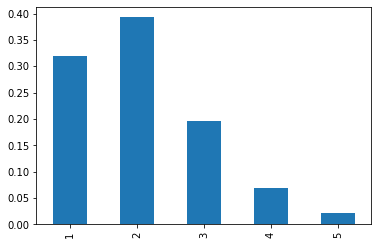

In [85]:
pre_covid['elr_bin5_class'].value_counts(normalize = True).sort_index().plot(kind = 'bar')

In [86]:
pre_covid['elr_bin5_class'].value_counts(normalize = True).sort_index()

1    0.319363
2    0.392852
3    0.197131
4    0.068906
5    0.021749
Name: elr_bin5_class, dtype: float64

### Feb 2020 distribution - right before covid

In [87]:
Feb2020 = combined2.loc[(combined2['listing_start_date'] >= '2020-02-01') & (combined2['listing_start_date'] <= '2020-02-28')]

Text(0.5, 1.0, 'Feb 2020 elr real distribution')

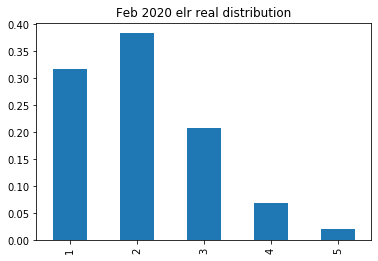

In [91]:
Feb2020['elr_bin5_class'].value_counts(normalize = True).sort_index().plot(kind = 'bar')
plt.title('Feb 2020 elr real distribution')

In [92]:
Feb2020['elr_bin5_class'].value_counts(normalize = True).sort_index()

1    0.317210
2    0.383384
3    0.208935
4    0.068413
5    0.022058
Name: elr_bin5_class, dtype: float64

In [93]:
observation = combined2.loc[(combined2['listing_start_date'] >= '2020-03-01') & (combined2['listing_start_date'] <= '2020-08-31')]

In [94]:
observation = observation[['listing_start_date', 'estimated_loss_rate', 'TUFicoRange_Nu', 'prosper_rating_nu']]

In [95]:
observation1 = pd.merge(observation, elr_5, left_index = True, right_index = True)
observation1.head()

,listing_start_date,estimated_loss_rate,TUFicoRange_Nu,prosper_rating_nu,elr_bin5_class,elr_bin5_class_hat
196,2020-03-12,0.0434,6,4,2,2
1453,2020-03-02,0.0389,5,5,2,2
189963,2020-03-18,0.0449,5,4,2,2
190000,2020-03-05,0.1075,4,2,3,4
190001,2020-03-23,0.0449,4,4,2,2


In [96]:
observation2 = pd.merge(observation1, elr_10, left_index = True, right_index = True)
observation2 = observation2.sort_values(by = 'listing_start_date')

In [97]:
observation2 = pd.merge(observation2, elr_20, left_index = True, right_index = True)
observation2 = observation2.sort_values(by = 'listing_start_date')

In [98]:
observation2.head()

,listing_start_date,estimated_loss_rate,TUFicoRange_Nu,prosper_rating_nu,elr_bin5_class,elr_bin5_class_hat,elr_bin10_class,elr_bin10_class_hat,elr_bin20_class,elr_bin20_class_hat
205666,2020-03-01,0.0389,2,5,2,2,3,3,5,5
222045,2020-03-01,0.0689,3,3,2,2,4,4,8,8
200027,2020-03-01,0.0674,3,3,2,2,4,5,8,8
198819,2020-03-01,0.0869,3,3,3,3,5,5,10,10
216976,2020-03-01,0.0464,2,4,2,2,3,3,5,6


### Distributions - real vs. predicted

In [99]:
import matplotlib.pyplot as plt

In [100]:
observation2['elr_bin5_class'].value_counts(normalize = True)

1    0.486269
2    0.382250
3    0.098680
4    0.025647
5    0.007154
Name: elr_bin5_class, dtype: float64

Text(0.5, 1.0, 'March - August 2020 real distribution')

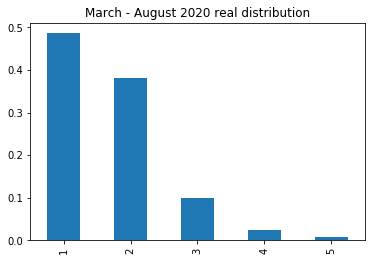

In [101]:
# real distribution - 5 classes 
observation2['elr_bin5_class'].value_counts(normalize = True).plot(kind = 'bar')
plt.title('March - August 2020 real distribution')

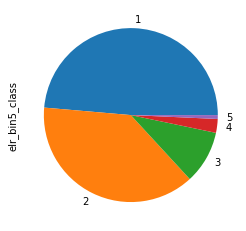

In [102]:
observation2['elr_bin5_class'].value_counts(normalize = True).plot(kind = 'pie')

In [103]:
observation2['elr_bin5_class_hat'].value_counts(normalize = True).sort_index()

1    0.300760
2    0.510870
3    0.154950
4    0.027249
5    0.006172
Name: elr_bin5_class_hat, dtype: float64

Text(0.5, 1.0, 'March - August 2020 predicted distribution')

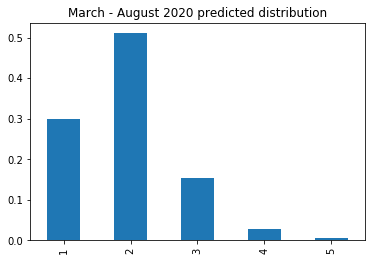

In [104]:
# predicted distribution - 5 classes
observation2['elr_bin5_class_hat'].value_counts(normalize = True).sort_index().plot(kind = 'bar')
plt.title('March - August 2020 predicted distribution')

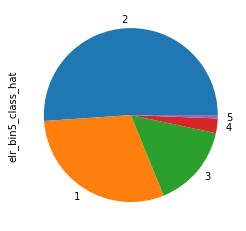

In [105]:
observation2['elr_bin5_class_hat'].value_counts(normalize = True).plot(kind = 'pie')

Text(0.5, 1.0, 'March - May 2020 real distribution')

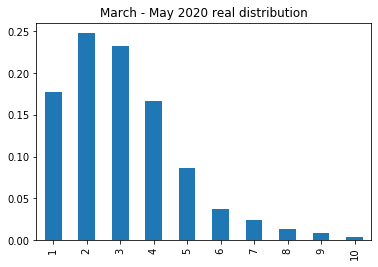

In [97]:
# real distribution - 10 classes
observation2['elr_bin10_class'].value_counts(normalize = True).sort_index().plot(kind = 'bar')
plt.title('March - May 2020 real distribution')

Text(0.5, 1.0, 'March - May 2020 predicted distribution')

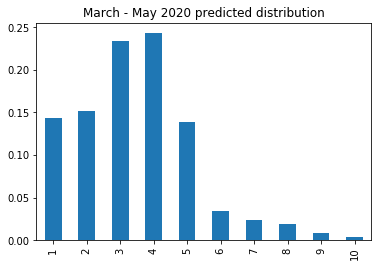

In [98]:
# predicted distribution - 10 classes 
observation2['elr_bin10_class_hat'].value_counts(normalize = True).sort_index().plot(kind = 'bar')
plt.title('March - May 2020 predicted distribution')

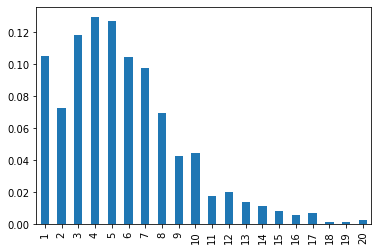

In [86]:
# real distribution - 20 classes
observation2['elr_bin20_class'].value_counts(normalize = True).sort_index().plot(kind = 'bar')

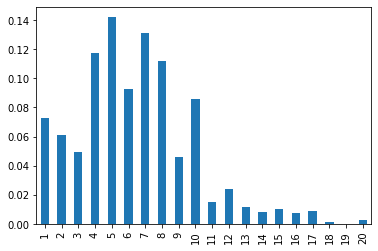

In [87]:
# predicted distribution - 20 classes
observation2['elr_bin20_class_hat'].value_counts(normalize = True).sort_index().plot(kind = 'bar')

### March 2020 Distribution

In [106]:
March = observation2.loc[(observation2['listing_start_date'] >= '2020-03-01') & (observation2['listing_start_date'] <= '2020-03-31')]

Text(0.5, 1.0, 'March 2020 real distribution')

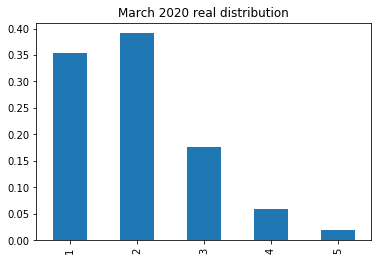

In [107]:
March['elr_bin5_class'].value_counts(normalize = True).sort_index().plot(kind = 'bar')
plt.title('March 2020 real distribution')

In [108]:
March['elr_bin5_class'].value_counts(normalize = True).sort_index()

1    0.354541
2    0.390883
3    0.177270
4    0.058546
5    0.018760
Name: elr_bin5_class, dtype: float64

Text(0.5, 1.0, 'March 2020 predicted distribution')

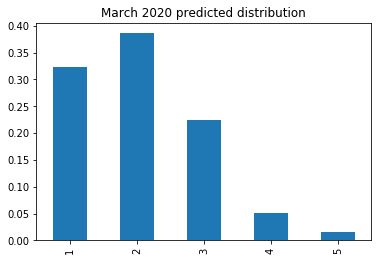

In [110]:
March['elr_bin5_class_hat'].value_counts(normalize = True).sort_index().plot(kind = 'bar')
plt.title('March 2020 predicted distribution')

In [111]:
March['elr_bin5_class_hat'].value_counts(normalize = True).sort_index()

1    0.322730
2    0.385989
3    0.223672
4    0.051659
5    0.015951
Name: elr_bin5_class_hat, dtype: float64

In [112]:
accuracy_score(March['elr_bin5_class'], March['elr_bin5_class_hat']) *100

89.98549936559725

### April 2020 Distribution

In [113]:
April = observation2.loc[(observation2['listing_start_date'] >= '2020-04-01') & (observation2['listing_start_date'] <= '2020-04-30')]

Text(0.5, 1.0, 'April 2020 real distribution')

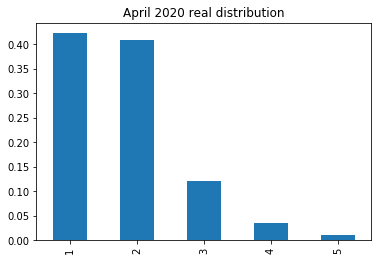

In [114]:
April['elr_bin5_class'].value_counts(normalize = True).plot(kind = 'bar')
plt.title('April 2020 real distribution')

In [115]:
April['elr_bin5_class'].value_counts(normalize = True)

1    0.422489
2    0.409084
3    0.122063
4    0.035641
5    0.010724
Name: elr_bin5_class, dtype: float64

Text(0.5, 1.0, 'April 2020 predicted distribution')

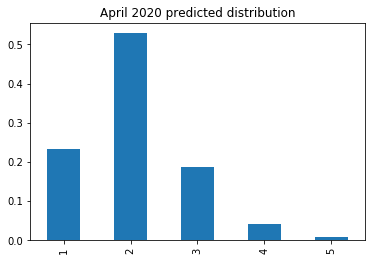

In [116]:
April['elr_bin5_class_hat'].value_counts(normalize = True).sort_index().plot(kind = 'bar')
plt.title('April 2020 predicted distribution')

In [279]:
April['elr_bin5_class_hat'].value_counts(normalize = True).sort_index()

1    0.233402
2    0.528466
3    0.186564
4    0.042895
5    0.008674
Name: elr_bin5_class_hat, dtype: float64

In [280]:
accuracy_score(April['elr_bin5_class'], April['elr_bin5_class_hat']) *100

72.1968143825895

### May 2020 distribution

In [281]:
May = observation2.loc[(observation2['listing_start_date'] >= '2020-05-01') & (observation2['listing_start_date'] <= '2020-05-31')]

Text(0.5, 1.0, 'May 2020 real distribution')

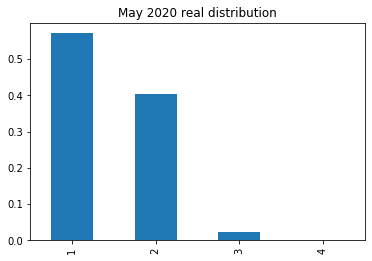

In [282]:
May['elr_bin5_class'].value_counts(normalize = True).plot(kind = 'bar')
plt.title('May 2020 real distribution')

In [283]:
May['elr_bin5_class'].value_counts(normalize = True)

1    0.571274
2    0.404968
3    0.021958
4    0.001800
Name: elr_bin5_class, dtype: float64

Text(0.5, 1.0, 'May 2020 predicted distribution')

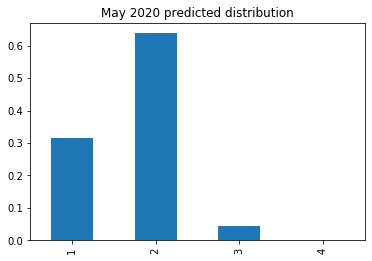

In [285]:
May['elr_bin5_class_hat'].value_counts(normalize = True).sort_index().plot(kind = 'bar')
plt.title('May 2020 predicted distribution')

In [286]:
May['elr_bin5_class_hat'].value_counts(normalize = True).sort_index()

1    0.315155
2    0.637689
3    0.044636
4    0.002520
Name: elr_bin5_class_hat, dtype: float64

In [287]:
accuracy_score(May['elr_bin5_class'], May['elr_bin5_class_hat']) *100

71.90424766018718

### June 2020 distribution

In [288]:
June = observation2.loc[(observation2['listing_start_date'] >= '2020-06-01') & (observation2['listing_start_date'] <= '2020-06-30')]

Text(0.5, 1.0, 'June 2020 real distribution')

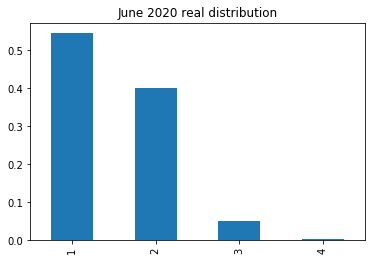

In [289]:
June['elr_bin5_class'].value_counts(normalize = True).plot(kind = 'bar')
plt.title('June 2020 real distribution')

Text(0.5, 1.0, 'June 2020 predicted distribution')

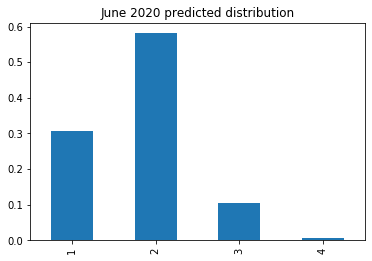

In [290]:
June['elr_bin5_class_hat'].value_counts(normalize = True).sort_index().plot(kind = 'bar')
plt.title('June 2020 predicted distribution')

In [291]:
accuracy_score(June['elr_bin5_class'], June['elr_bin5_class_hat']) *100

69.63142412182039

### July

In [292]:
July = observation2.loc[(observation2['listing_start_date'] >= '2020-07-01') & (observation2['listing_start_date'] <= '2020-07-31')]

Text(0.5, 1.0, 'July 2020 real distribution')

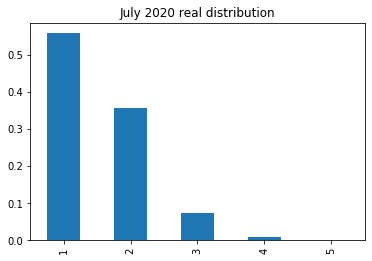

In [293]:
July['elr_bin5_class'].value_counts(normalize = True).plot(kind = 'bar')
plt.title('July 2020 real distribution')

Text(0.5, 1.0, 'July 2020 predicted distribution')

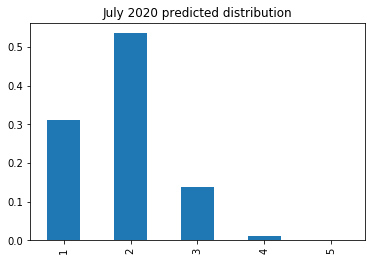

In [294]:
July['elr_bin5_class_hat'].value_counts(normalize = True).sort_index().plot(kind = 'bar')
plt.title('July 2020 predicted distribution')

In [295]:
accuracy_score(July['elr_bin5_class'], July['elr_bin5_class_hat']) *100

67.87370280415102

In [296]:
Aug = observation2.loc[(observation2['listing_start_date'] >= '2020-08-01') & (observation2['listing_start_date'] <= '2020-08-31')]

Text(0.5, 1.0, 'Aug 2020 real distribution')

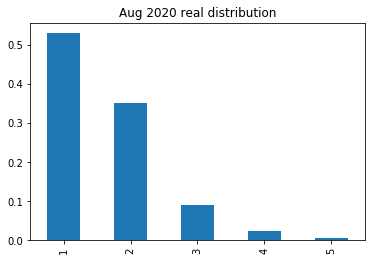

In [297]:
Aug['elr_bin5_class'].value_counts(normalize = True).plot(kind = 'bar')
plt.title('Aug 2020 real distribution')

Text(0.5, 1.0, 'Aug 2020 predicted distribution')

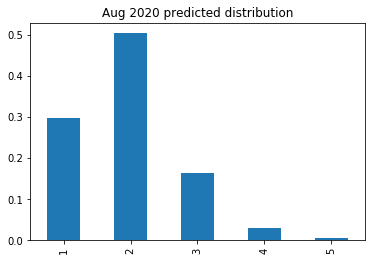

In [298]:
Aug['elr_bin5_class_hat'].value_counts(normalize = True).sort_index().plot(kind = 'bar')
plt.title('Aug 2020 predicted distribution')

In [299]:
accuracy_score(Aug['elr_bin5_class'], Aug['elr_bin5_class_hat']) *100

67.35099337748345

### post-covid overall distribution

In [377]:
post_covid = combined2.loc[(combined2['listing_start_date'] >= '2020-03-01') & (combined2['listing_start_date'] <= '2020-10-31')]

In [335]:
post_covid = post_covid[['listing_start_date', 'estimated_loss_rate', 'elr_bin5_class','TUFicoRange_Nu', 'prosper_rating_nu']]

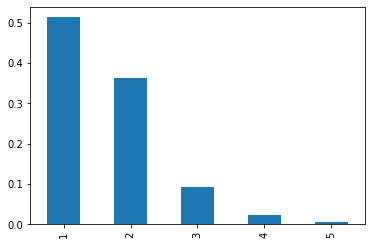

In [342]:
post_covid['elr_bin5_class'].value_counts(normalize = True).plot(kind = 'bar')

In [340]:
Sep = post_covid.loc[(post_covid['listing_start_date'] >= '2020-09-01') & (post_covid['listing_start_date'] <= '2020-09-30')]

Text(0.5, 1.0, 'Sep 2020 real distribution')

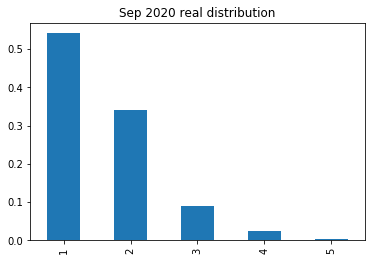

In [341]:
Sep['elr_bin5_class'].value_counts(normalize = True).plot(kind = 'bar')
plt.title('Sep 2020 real distribution')

In [343]:
Oct = post_covid.loc[(post_covid['listing_start_date'] >= '2020-10-01') & (post_covid['listing_start_date'] <= '2020-10-31')]

Text(0.5, 1.0, 'Oct 2020 real distribution')

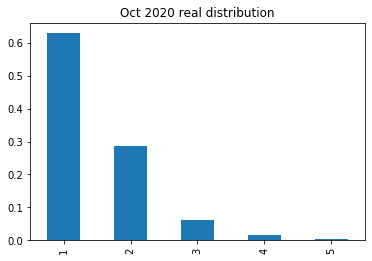

In [344]:
Oct['elr_bin5_class'].value_counts(normalize = True).plot(kind = 'bar')
plt.title('Oct 2020 real distribution')

### dataset exploration - interesting findings (sub1)

In [357]:
# examine the estimated loss rate for thoese who are not funded at all
zero_fund = sub2_train.loc[sub2_train['percent_funded'] == 0]
elr_zero_fund = zero_fund['estimated_loss_rate']
elr_zero_fund.value_counts().shape

(117,)

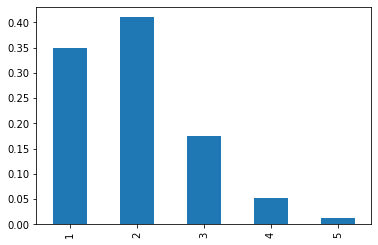

In [361]:
zero_fund['elr_bin5_class'].value_counts(normalize = True).sort_index().plot(kind ='bar')

In [367]:
zero_fund['elr_bin5_class'].value_counts(normalize = True).sort_index()

1    0.350338
2    0.410203
3    0.174909
4    0.052056
5    0.012493
Name: elr_bin5_class, dtype: float64

In [364]:
# examine the estimated loss rate for thoese who are funded 100%
total_fund = sub2_train.loc[sub2_train['percent_funded'] == 100]
elr_total_fund = total_fund['estimated_loss_rate']
elr_total_fund.describe()

count    179236.000000
mean          0.058313
std           0.034420
min           0.002700
25%           0.032400
50%           0.052400
75%           0.077400
max           0.177500
Name: estimated_loss_rate, dtype: float64

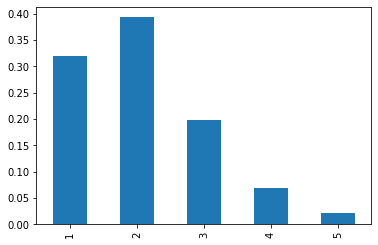

In [365]:
total_fund['elr_bin5_class'].value_counts(normalize = True).sort_index().plot(kind ='bar')

In [366]:
total_fund['elr_bin5_class'].value_counts(normalize = True).sort_index()

1    0.319484
2    0.393024
3    0.197360
4    0.068647
5    0.021486
Name: elr_bin5_class, dtype: float64

In [368]:
# examine the estimated loss rate for thoese who are only partially funded
partial_fund = sub2_train.loc[(sub2_train['percent_funded'] != 100) & (sub2_train['percent_funded'] != 0)]
elr_partial_fund = partial_fund['estimated_loss_rate']
elr_partial_fund.describe()

count    555.000000
mean       0.087332
std        0.047757
min        0.002700
25%        0.047400
50%        0.084900
75%        0.125900
max        0.177500
Name: estimated_loss_rate, dtype: float64

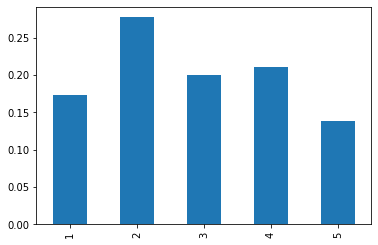

In [369]:
partial_fund['elr_bin5_class'].value_counts(normalize = True).sort_index().plot(kind ='bar')

In [384]:
partial_fund['elr_bin5_class'].value_counts(normalize = True).sort_index()

1    0.172973
2    0.277477
3    0.200000
4    0.210811
5    0.138739
Name: elr_bin5_class, dtype: float64

### post covid

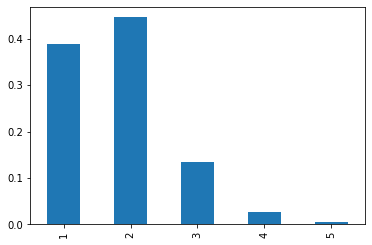

In [378]:
zero_fund_1 = post_covid.loc[post_covid['percent_funded'] == 0]
zero_fund_1['elr_bin5_class'].value_counts(normalize = True).sort_index().plot(kind ='bar')

In [383]:
zero_fund_1['elr_bin5_class'].value_counts(normalize = True).sort_index()

1    0.388486
2    0.446054
3    0.133816
4    0.027449
5    0.004194
Name: elr_bin5_class, dtype: float64

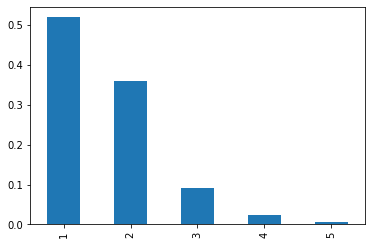

In [379]:
total_fund_1 = post_covid.loc[post_covid['percent_funded'] == 100]
total_fund_1['elr_bin5_class'].value_counts(normalize = True).sort_index().plot(kind ='bar')

In [381]:
total_fund_1['elr_bin5_class'].value_counts(normalize = True).sort_index()

1    0.519139
2    0.359824
3    0.090512
4    0.023982
5    0.006543
Name: elr_bin5_class, dtype: float64

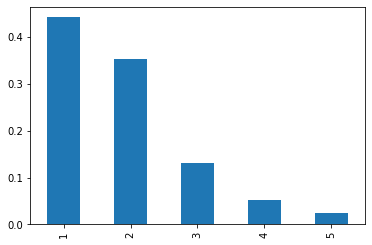

In [380]:
partial_fund_1 = post_covid.loc[(post_covid['percent_funded'] != 100) & (post_covid['percent_funded'] != 0)]
partial_fund_1['elr_bin5_class'].value_counts(normalize = True).sort_index().plot(kind ='bar')

In [382]:
partial_fund_1['elr_bin5_class'].value_counts(normalize = True).sort_index()

1    0.441379
2    0.351724
3    0.131034
4    0.051724
5    0.024138
Name: elr_bin5_class, dtype: float64

Prosper adjusted the model after covid to make borrowers look less risky. 

On Prosper's website, they claimed that they would tighten their lending model during an economic downturn to protect investors. The data show that is not the case. 

possible motivations: increase liquidity for borrowers and help them in this difficult time (social causes). Make sure investors have a brighter perception on borrowers so they would keep investing. This would ensure the platform doesn't go bankrupt and keep operating. 

Investors become more risk averse after the burst of the pandemic. They focus more on the estimated loss rate when they make the decisions on the percentage funding they are willing to provide. However, since Prosper adjusted its model, the estimated loss rate may not reflect the same amount of risk compare to the pre-covid period. Investors should do their own research instead of relying on the data/scores provided by the platform to make the right decisions during an economic downturn.

https://www.cnbc.com/2020/04/15/solo-funds-offers-interest-free-microloans-to-millions-of-americans.html

https://www.reuters.com/article/us-funding-circle-trading/funding-circle-operating-losses-rise-but-sees-long-term-lending-opportunity-idUSKCN26F0QQ



### Random Forest Feature selections - may be used for dimensional reduction 

In [67]:
feature_names = X.columns.tolist()

In [68]:
feature_ranks = pd.DataFrame({'feature_names':feature_names,'scores': rfc.feature_importances_}, columns = ['feature_names', 'scores'])

In [69]:
feature_ranks = feature_ranks.sort_values(by = ['scores'], ascending = False)
feature_ranks.set_index('feature_names', inplace = True)

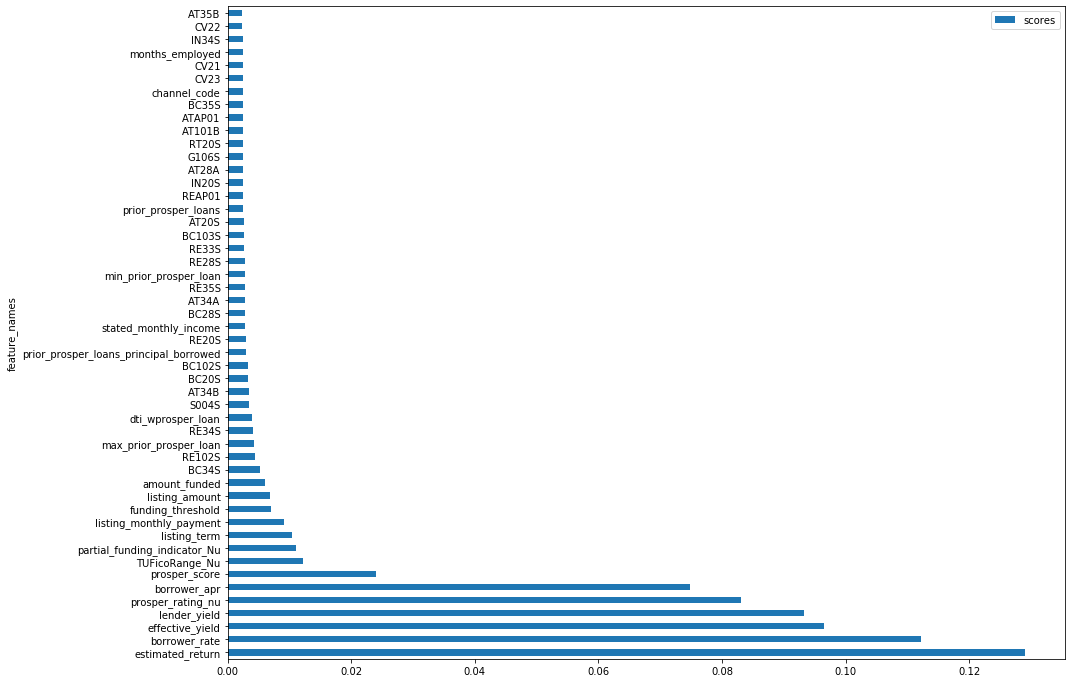

In [72]:
# visualize the top 50 importance features 
import matplotlib.pyplot as plt
feature_ranks.head(50).plot(kind = 'barh', figsize = (15,12))